In [1]:
import scanpy as sc
import pandas as pd
import decoupler as dc
import numpy as np
import os
import re

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import seaborn as sns

In [3]:
# Define input and output files
if 'snakemake' in locals():
    tissue = snakemake.wildcards[0]

    cellprop_cutoff = snakemake.params[0]

    adata_fp = snakemake.input[0]
    ctProp_fp = snakemake.input[1]
    ct_annot_fp = snakemake.input[2]

    output_fp = snakemake.output[0]

else:
    tissue = 'brain'
    
    sig_thresh = 0.05
    cellprop_cutoff = 0.05

    adata_fp = 'results/ST/{0}_wImages.h5ad'.format(tissue)
    ctProp_fp = 'results/ST/ST_{0}_deconvoluted.csv'.format(tissue)
    ct_annot_fp = 'data/original/MO/MO_cluster_metadata.csv'


In [7]:
adata = sc.read_h5ad(adata_fp)
print(adata)

AnnData object with n_obs × n_vars = 29770 × 14630
    obs: 'in_tissue', 'array_row', 'array_col', 'library_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'mouse', 'condition', 'seurat_clusters', 'SCT_snn_res.0.44', 'SCT_snn_res.0.5', 'annot'
    uns: 'spatial'
    obsm: 'harmony', 'pca', 'spatial', 'umap'
    layers: 'SCT'


In [21]:
annot = pd.read_csv(ct_annot_fp)
annot

,clusterID,clusterName,clusterAbrv
0,X0,Neurogenesis-I,Neuro.I
1,X1,Synaptic-transmission-I,Syn.Trans.I
2,X2,Neuronal-activity-synaptic-transmission-I,Neuro.act.Syn.Trans.I
3,X3,Myelination,Myelination
4,X4,Astrocytes,Astrocytes
5,X5,Glutamatergic-synaptic-transmission-I,Glut.Syn.Trans.I
6,X6,Glutamatergic-synaptic-transmission-II,Glut.Syn.Trans.II
7,X7,Glial-development,Glial.dev
8,X8,Glutamatergic-synaptic-transmission-III,Glut.Syn.Trans.III
9,X9,Neurogenesis-II,Neuro.II


In [47]:
ctProp = pd.read_csv(ctProp_fp, index_col=0)
ctProp = ctProp.where(ctProp >= cellprop_cutoff)
ctProp = pd.merge(ctProp, adata.obs.filter(['library_id'], axis = 1), left_index=True, right_index=True)

In [99]:
counts = ctProp.groupby(['library_id']).count().reset_index()
counts.columns = ['library_id'] + annot['clusterAbrv'].tolist()
counts = pd.melt(counts, id_vars='library_id', var_name='celltype', value_name='count')
counts = pd.merge(adata.obs.filter(['library_id', 'mouse', 'condition'], axis=1).drop_duplicates().reset_index(drop = True), counts, on='library_id')

,library_id,mouse,condition,celltype,count
0,Sample_158_A1,CF2,flight,Neuro.I,645
1,Sample_158_A1,CF2,flight,Syn.Trans.I,665
2,Sample_158_A1,CF2,flight,Neuro.act.Syn.Trans.I,1307
3,Sample_158_A1,CF2,flight,Myelination,647
4,Sample_158_A1,CF2,flight,Astrocytes,846
...,...,...,...,...,...
211,Sample_304_D1,CG8,ground,Neuro.act.Syn.Trans.II,271
212,Sample_304_D1,CG8,ground,Neuro.endo,471
213,Sample_304_D1,CG8,ground,Neuro.act.Syn.Trans.III,484
214,Sample_304_D1,CG8,ground,Glut.Syn.Trans.IV,276


In [102]:
medians = ctProp.groupby(['library_id']).median().reset_index()
medians.columns = ['library_id'] + annot['clusterAbrv'].tolist()
medians = pd.melt(medians, id_vars='library_id', var_name='celltype', value_name='median')
medians = pd.merge(adata.obs.filter(['library_id', 'mouse', 'condition'], axis=1).drop_duplicates().reset_index(drop = True), medians, on='library_id')

,library_id,mouse,condition,celltype,median
0,Sample_158_A1,CF2,flight,Neuro.I,0.094406
1,Sample_158_A1,CF2,flight,Syn.Trans.I,0.177299
2,Sample_158_A1,CF2,flight,Neuro.act.Syn.Trans.I,0.395516
3,Sample_158_A1,CF2,flight,Myelination,0.125103
4,Sample_158_A1,CF2,flight,Astrocytes,0.086585
...,...,...,...,...,...
211,Sample_304_D1,CG8,ground,Neuro.act.Syn.Trans.II,0.129154
212,Sample_304_D1,CG8,ground,Neuro.endo,0.105115
213,Sample_304_D1,CG8,ground,Neuro.act.Syn.Trans.III,0.115462
214,Sample_304_D1,CG8,ground,Glut.Syn.Trans.IV,0.101625


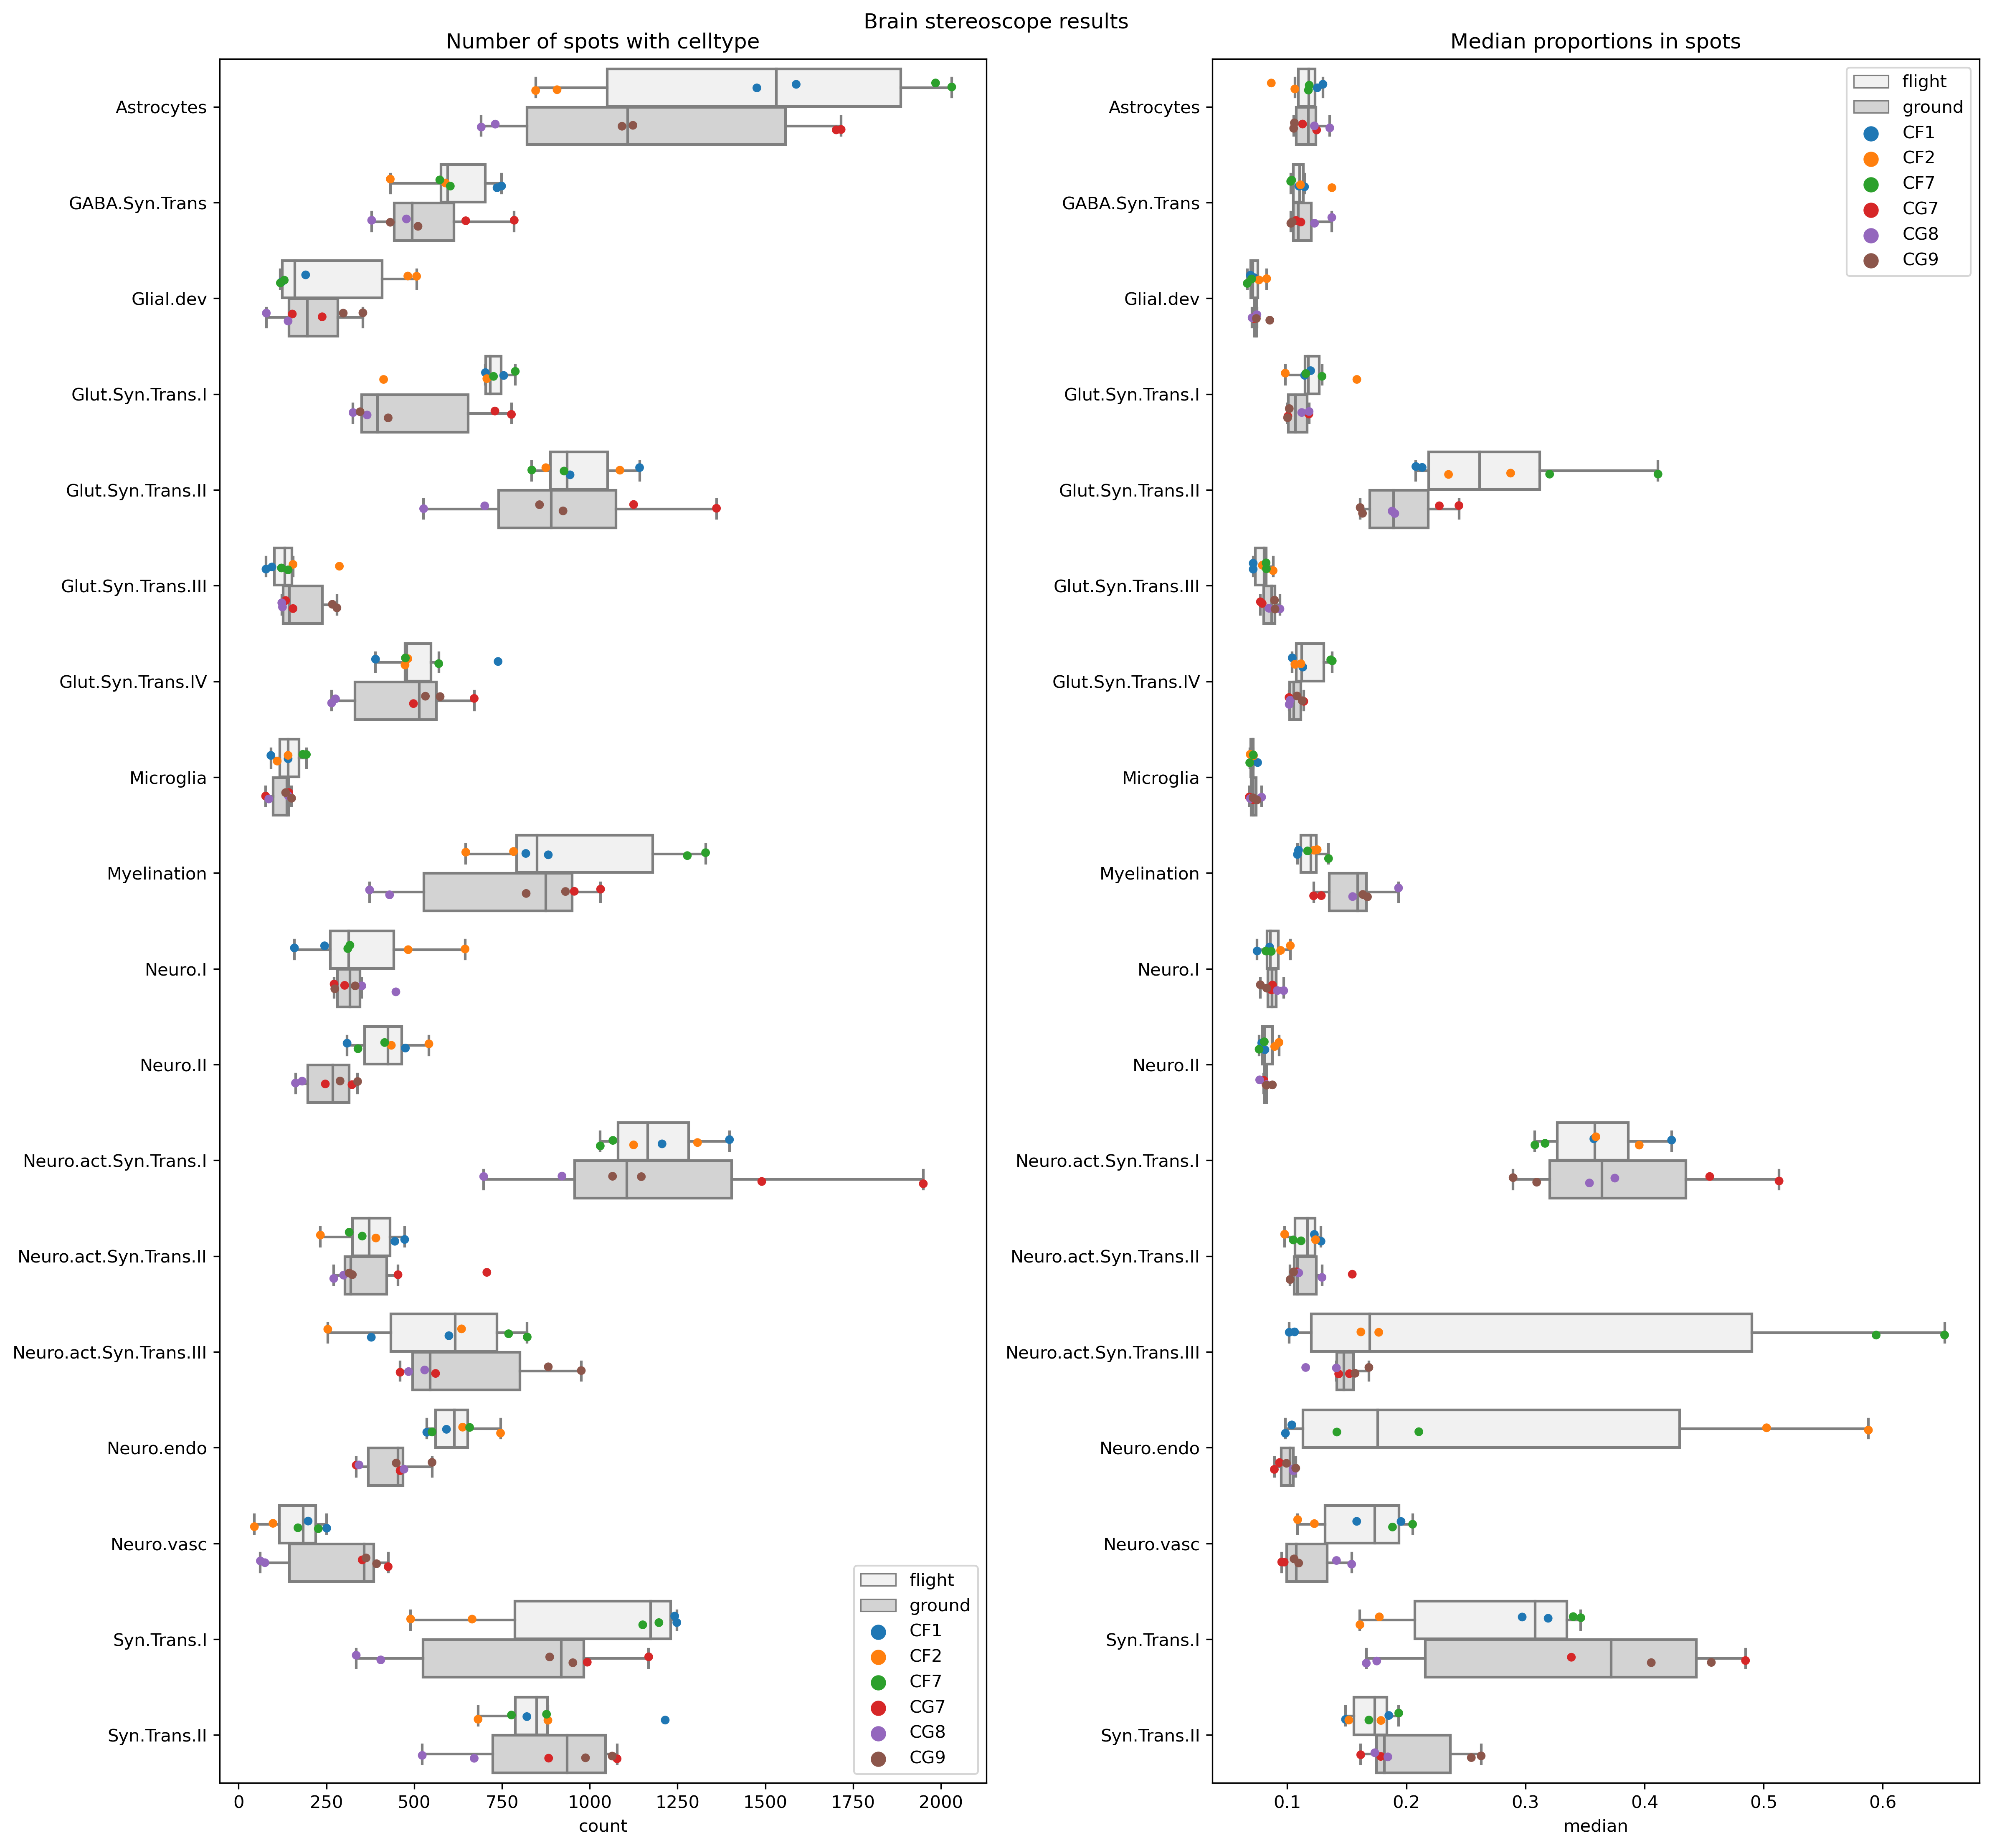

In [110]:
colors = sns.color_palette("tab10").as_hex()[0:6]

fig, axes = plt.subplots(1, 2 , figsize=(16, 15), dpi = 300)
axes = axes.flatten()


for df, name, ax in zip([counts, medians], ['count', 'median'], axes):

    sns.boxplot(data = df, x=name, y= 'celltype', hue = 'condition', color = 'lightgrey', order=annot['clusterAbrv'].sort_values(), fliersize=0, ax=ax)

    for mouse, color in zip(sorted(df['mouse'].unique()), colors):
        mouse_toplot = df[df['mouse'] == mouse]
        sns.stripplot(x=name, y='celltype', hue='condition', dodge=True, palette=[color] * 2, marker='o', data=mouse_toplot, order=annot['clusterAbrv'].sort_values(), ax=ax)

    handles, labels = ax.get_legend_handles_labels()
    handles = handles[0:2] + handles[2:-1:2]
    labels = labels[0:2] + sorted(counts['mouse'].unique())
    ax.legend(handles, labels)

axes[0].set_title('Number of spots with celltype')
axes[1].set_title('Median proportions in spots')
axes[0].set_ylabel('')
axes[1].set_ylabel('')

plt.suptitle(tissue.capitalize() + ' stereoscope results')
plt.tight_layout()
plt.savefig('test.pdf')

# sns.stripplot(x='count', y='celltype', hue='condition', dodge=True, marker='o', data=counts, order=annot['clusterAbrv'].sort_values())